In [1]:
import pandas as pd
import numpy as np
import re
import time

import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv('Q2.csv')

FileNotFoundError: ignored

## EDA

#### Basic overview of the data

In [ ]:
df.shape

(2497, 12)

In [ ]:
df.sample(frac=0.005)

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,DEFAULT
1856,40000,60,0.0485,250000.0,727,Credit Card Refinancing,RENT,CA,Unknown,2019,3,1
2330,18000,60,0.1913,118000.0,697,Debt Consolidation,MORTGAGE,FL,Office,2019,10,0
2102,6650,36,17.9400,120000.0,515,debt_consolidation,rent,IN,Driver/Transportation,2018,3 years,0
1224,8000,36,0.3142,66000.0,667,Debt Consolidation,RENT,CT,NaN,2020,< 1 year,1
2341,2200,36,0.2318,60000.0,712,Other,MORTGAGE,CA,Skilled Labor,2018,27,0
1874,20000,36,0.1621,56350.0,717,Debt Consolidation,RENT,NY,Office,2019,10,0
291,25000,36,0.3794,119800.0,702,Credit Card Refinancing,OWN,VA,Legal/Government/Police,2018,10,0
2127,35000,36,0.3562,95000.0,797,Debt Consolidation,RENT,AZ,Sales,2018,10,0
29,8000,36,0.1076,26000.0,662,Debt Consolidation,RENT,AZ,Food/Hospitality,2019,1,0
2138,20000,60,0.0991,54600.0,677,Home Improvement,MORTGAGE,TX,Others,2019,2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2497 entries, 0 to 2496
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Feature1   2497 non-null   int64  
 1   Feature2   2497 non-null   int64  
 2   Feature3   2497 non-null   float64
 3   Feature4   2497 non-null   float64
 4   Feature5   2497 non-null   int64  
 5   Feature6   2497 non-null   object 
 6   Feature7   2497 non-null   object 
 7   Feature8   2497 non-null   object 
 8   Feature9   2094 non-null   object 
 9   Feature10  2497 non-null   int64  
 10  Feature11  2293 non-null   object 
 11  DEFAULT    2497 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 234.2+ KB


There are some features that have missing values. Let's check how many

In [ ]:
print('-- Missing values --')
df.isnull().sum()

-- Missing values --


Feature1       0
Feature2       0
Feature3       0
Feature4       0
Feature5       0
Feature6       0
Feature7       0
Feature8       0
Feature9     403
Feature10      0
Feature11    204
DEFAULT        0
dtype: int64

In [ ]:
# Some basic statistics for each numerical data column

df.describe()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature10,DEFAULT
count,2497.000000,2497.000000,2497.000000,2.497000e+03,2497.000000,2497.000000,2497.000000
mean,17638.065679,45.813376,2.878437,9.429375e+04,694.590308,2018.920705,0.130957
std,10085.407799,11.801460,9.132207,1.047615e+05,33.144859,0.588450,0.337421
min,1000.000000,36.000000,0.000000,6.500000e+03,490.000000,2017.000000,0.000000
25%,10000.000000,36.000000,0.149400,5.312800e+04,672.000000,2019.000000,0.000000
50%,15950.000000,36.000000,0.223800,7.850000e+04,687.000000,2019.000000,0.000000
75%,25000.000000,60.000000,0.322300,1.150000e+05,712.000000,2019.000000,0.000000
max,40000.000000,60.000000,299.140000,4.255262e+06,832.000000,2020.000000,1.000000


Segregating categorical features and numerical features

In [ ]:
cat_features = ['Feature6','Feature7','Feature8','Feature9']
num_features = df.select_dtypes(include=['int64','float64']).columns

That leaves us with <i>Feature11</i>. Let's check

In [ ]:
df['Feature11'].unique()

array(['3', '20', '2 years', '0', '7', '< 1 year', '10', '4', '12', nan,
       '6', '11', '1', '2', '16', '9', '25', '5', '23', '6 years',
       '9 years', '21', '8', '7 years', '10+ years', '15', '8 years',
       '17', '14', '4 years', '13', '27', '1 year', '26', '30', '3 years',
       '5 years', '31', '22', '19', '35', '18', '24', '40', '32', '29',
       '37', '28', '33', '36'], dtype=object)

<b>Note</b>: <i>Feature11</i> looks to be majorly numeric, i.e., no. of years. I assume it as numeric and will handle standardization later

#### Distributions

In [ ]:
df.nunique()

Feature1      365
Feature2        2
Feature3     1914
Feature4      581
Feature5       86
Feature6       23
Feature7        7
Feature8       50
Feature9       16
Feature10       4
Feature11      49
DEFAULT         2
dtype: int64

Firstly, let's check the distribution of the target variable - DEFAULT

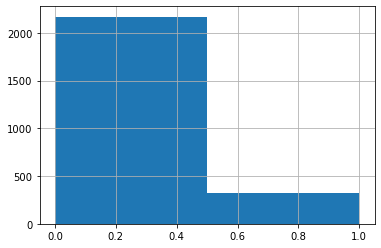

In [ ]:
df['DEFAULT'].hist(bins=2)

In [ ]:
df['DEFAULT'].value_counts() * 100 / df['DEFAULT'].count()

0    86.904285
1    13.095715
Name: DEFAULT, dtype: float64

As we can see, the classes are quite imbalanced. Only about 13% of the dataset has DEFAULT = 1 label

#### Visualizing pair-wise relationships among numerical features

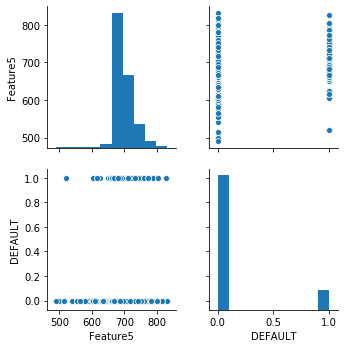

In [ ]:
sns.pairplot(df[['Feature5','DEFAULT']])

In [ ]:
# sns.pairplot(df)

To help us understand the distributions of features and their relationship with each other and with the label, I'll create a few more visualizations after data-cleaning

## Data Cleaning

#### Feature11

As previously identified, <i>Feature11</i> looks heterogenous. Let's start with that

In [ ]:
df['Feature11'].unique()

array(['3', '20', '2 years', '0', '7', '< 1 year', '10', '4', '12', nan,
       '6', '11', '1', '2', '16', '9', '25', '5', '23', '6 years',
       '9 years', '21', '8', '7 years', '10+ years', '15', '8 years',
       '17', '14', '4 years', '13', '27', '1 year', '26', '30', '3 years',
       '5 years', '31', '22', '19', '35', '18', '24', '40', '32', '29',
       '37', '28', '33', '36'], dtype=object)

Extracting a numeric value from <i>Feature11</i>. For the sake of simplicity, let's take just the number without the '<' or '+' quantifiers

In [ ]:
# using regex to extract the number

def extract_years(s):
    x = re.search("\d+", str(s))
    if x:
        return int(x.group())
    else:
        return np.nan

In [ ]:
df['Feature11'] = df['Feature11'].apply(extract_years)

In [ ]:
df['Feature11'].unique()

array([ 3., 20.,  2.,  0.,  7.,  1., 10.,  4., 12., nan,  6., 11., 16.,
        9., 25.,  5., 23., 21.,  8., 15., 17., 14., 13., 27., 26., 30.,
       31., 22., 19., 35., 18., 24., 40., 32., 29., 37., 28., 33., 36.])

In [ ]:
sum(df['Feature11'].isna()) / len(df['Feature11'])

0.0816980376451742

Let's deal with the missing values now. We have 204 missing values in <i>Feature11</i>. That's about 8% of the total sample. So, ignoring corresponding samples is not an option. We could use a model to 'predict' those missing values and fill them, but with the limitation that we don't yet know what the feature really is, and its impact on the target label, I use a simple technique of replacing it with the mean of all the samples, and round it to the nearest integer

In [ ]:
df['Feature11'].fillna(round(df['Feature11'].mean()), inplace=True)

In [ ]:
sum(df['Feature11'].isna())

0

Now that we have <i>Feature11</i> as a numeric value and have handled missing values, let's visualize its distribution

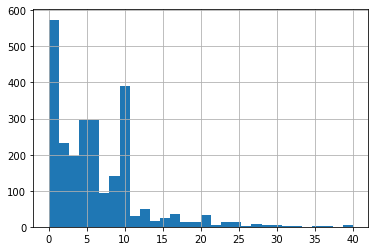

In [ ]:
df['Feature11'].hist(bins=30)

#### Feature6

Let's move on to the categorical features. Values in <i>Feature6</i> look repetitive with minor differences, hence standardizing

In [ ]:
df['Feature6'] = df['Feature6'].apply(str.lower)

In [ ]:
df['Feature6'].value_counts()

debt consolidation         1229
credit card refinancing     466
debt_consolidation          223
other                       161
home improvement            124
credit_card                 106
other major purchase         29
business                     25
home_improvement             24
medical expenses             23
home purchase                20
vehicle purchase             17
vacation                     17
moving or relocation         13
major_purchase                7
house                         4
medical                       4
car                           2
small_business                1
green loan                    1
moving                        1
Name: Feature6, dtype: int64

In [ ]:
# creating a mapping dictionary for standardization

replace_dict = {
    'debt_consolidation'  : 'debt consolidation',
    'credit_card'         : 'credit card refinancing',
    'home_improvement'    : 'home improvement',
    'car'                 : 'vehicle purchase',
    'small_business'      : 'business',
    'other major purchase': 'other',
    'medical expenses'    : 'medical',
    'house'               : 'home purchase',
    'major_purchase'      : 'other',
    'moving or relocation': 'moving'
}

In [ ]:
df['Feature6'].replace(replace_dict, inplace=True)

Now that we've standardized, let's check the proportion of occurances of each category in <i>Feature6</i>

In [ ]:
feature6_freq = df['Feature6'].value_counts() * 100 / df['Feature6'].count()

In [ ]:
feature6_freq

debt consolidation         58.149780
credit card refinancing    22.907489
other                       7.889467
home improvement            5.927113
medical                     1.081298
business                    1.041249
home purchase               0.961153
vehicle purchase            0.760913
vacation                    0.680817
moving                      0.560673
green loan                  0.040048
Name: Feature6, dtype: float64

While the top 4 categories make up almost 95% of the data, the other categories do not account for much and may add noise to the model. Let's bucket them in <i>'other'</i> category

In [ ]:
feature6_noise = list(feature6_freq[feature6_freq < 5].index)

In [ ]:
replace_dict2 = {x:'other' for x in feature6_noise}

In [ ]:
df['Feature6'].replace(replace_dict2, inplace=True)

In [ ]:
df['Feature6'].value_counts()

debt consolidation         1452
credit card refinancing     572
other                       325
home improvement            148
Name: Feature6, dtype: int64

#### Feature7

In [ ]:
df['Feature7'].value_counts()

MORTGAGE    930
RENT        894
OWN         272
mortgage    211
rent        140
own          45
ANY           5
Name: Feature7, dtype: int64

As seen above, categories in <i>Feature7</i> are repetitive. Converting all to lowercase

In [ ]:
df['Feature7'] = df['Feature7'].apply(str.lower)

In [ ]:
df['Feature7'].value_counts()

mortgage    1141
rent        1034
own          317
any            5
Name: Feature7, dtype: int64

The category <i>'any'</i> occurs only in 5 samples in the dataset, amounting to ~ 0.2% of the samples. Having an extra category with such low frequency might not add additional value to the model, and might even create noise. I'll consider them as missing values and replace with most frequent value, i.e., <i>'mortgage'</i>

In [ ]:
df['Feature7'].replace({'any':'mortgage'}, inplace=True)

In [ ]:
df['Feature7'].value_counts()

mortgage    1146
rent        1034
own          317
Name: Feature7, dtype: int64

#### Feature 9

In [ ]:
df['Feature9'].value_counts(dropna=False)

Office                     491
NaN                        403
Others                     392
Skilled Labor              233
Health care                155
IT/Engineering             111
Sales                      109
Driver/Transportation       99
Legal/Government/Police     84
Education                   76
Unknown                     72
Construction/Labor          68
Food/Hospitality            60
Small Business              54
Customer Service            52
Real Estate                 26
Travel                      12
Name: Feature9, dtype: int64

<i>Feature9</i> has 403 missing values, and is almost as frequent as the highest real category, <i>'Office'</i>. We can categorize it as 'Missing'. However, there is also an another category called <i>'Unknown'</i>. I replace all missing values with <i>'Unknown'</i>, assuming that the missing values are indeed not known to us

In [ ]:
df['Feature9'].fillna('Unknown', inplace=True)

In [ ]:
df['Feature9'].value_counts()

Office                     491
Unknown                    475
Others                     392
Skilled Labor              233
Health care                155
IT/Engineering             111
Sales                      109
Driver/Transportation       99
Legal/Government/Police     84
Education                   76
Construction/Labor          68
Food/Hospitality            60
Small Business              54
Customer Service            52
Real Estate                 26
Travel                      12
Name: Feature9, dtype: int64

In [ ]:
df['Feature9'].value_counts() * 100 / df['Feature9'].count()

Office                     19.663596
Unknown                    19.022827
Others                     15.698839
Skilled Labor               9.331197
Health care                 6.207449
IT/Engineering              4.445334
Sales                       4.365238
Driver/Transportation       3.964758
Legal/Government/Police     3.364037
Education                   3.043652
Construction/Labor          2.723268
Food/Hospitality            2.402883
Small Business              2.162595
Customer Service            2.082499
Real Estate                 1.041249
Travel                      0.480577
Name: Feature9, dtype: float64

This is how our cleaned dataset looks like

In [ ]:
df.sample(frac=0.005, random_state=42)

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,DEFAULT
2292,40000,60,5.0800,198000.0,745,other,mortgage,VA,Office,2020,8.0,0
2399,26575,60,0.3061,110000.0,697,debt consolidation,mortgage,NY,Skilled Labor,2019,9.0,0
902,22500,60,0.1450,142000.0,662,credit card refinancing,mortgage,WA,Office,2018,2.0,0
2238,6000,36,0.0888,53000.0,687,debt consolidation,own,MD,Office,2019,0.0,0
1285,35000,60,0.1315,105000.0,822,debt consolidation,mortgage,PA,IT/Engineering,2019,2.0,0
56,35000,60,0.2175,70000.0,702,debt consolidation,mortgage,TX,Legal/Government/Police,2019,10.0,0
1987,40000,60,0.2646,101000.0,712,other,mortgage,PA,Unknown,2019,6.0,0
802,40000,36,0.2152,92720.0,702,debt consolidation,rent,CA,Unknown,2019,1.0,0
812,10000,36,0.2506,96000.0,692,credit card refinancing,rent,TX,Skilled Labor,2019,5.0,1
903,16000,60,0.2464,33600.0,697,debt consolidation,mortgage,NC,Unknown,2019,0.0,0


In [ ]:
# sns.pairplot(df)

## Feature Selection

<p>It is usually observed that when the right features are used for training, the model performs better than using the entire available dataset. Too many features may hinder accuracy, might cause the learning to slow down, increases complexity, and compromises model interpretability. Therefore, it is important for us to wisely choose those features that explain the target variable well. </p>
<p>As a sanity check for for being able to classify, I use <b> Logistic Regression </b> and <b> Random Forst Classification. </b> Additionally, I also use these 2 algos to help me in determining the importance of features, as it can be an iterative process


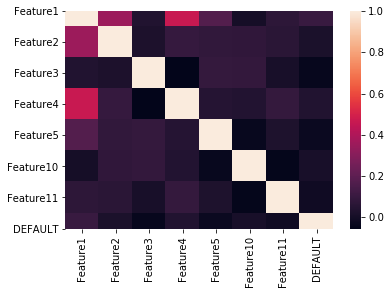

In [ ]:
# I use the Spearman Rank Correlation for pairwise correlation between the numerical features

corr_matrix = df.corr('spearman')
# corr_matrix
sns.heatmap(corr_matrix)

To address the categorical variables, I use One Hot Encoding for the features with fewer distinct categories (<i>Feature8, Feature9</i>, and LabelEncoding for features with a lot of distinct categories (<i>Feature6, Feature7</i>).<br><br>
<b>Rationale</b>: <li>OHE creates as many number of dimensions as distinct values. Creating a lot of features will make our algorithm face the <i>Curse of Dimensionality</i>. Moreover, tree based algorithms like Random Forest will lose out on the essense of the original feature when it is broken into multiple "features"
<li>Label Encoding assigns numerical values to categories, which the usual learning algorithm might mistake for ordinality even when the data is nominal. Random Forests tend to work alright even when used for nominal data
<br><br>Because of the above 2 reasons, I've chosen OHE for 2 features and Label Encoding for 2 other features

In [ ]:
df2 = df.copy()

In [ ]:
# OHE - Feature6 and Feature7

df_f6 = pd.get_dummies(data=df2['Feature6'])
df_f6.rename({x:'Feature6_'+x.replace(' ','_') for x in df_f6.columns}, axis=1, inplace=True)

df_f7 = pd.get_dummies(data=df2['Feature7'])
df_f7.rename({x:'Feature7_'+x.replace(' ','_') for x in df_f7.columns}, axis=1, inplace=True)

df2 = pd.concat([df2, df_f6, df_f7], axis=1).drop(['Feature6','Feature7'], axis=1)

In [ ]:
# Label Encoding Feature8 and Feature9

enc = LabelEncoder()
df2['Feature8_Cat'] = enc.fit_transform(df2['Feature8'])
df2['Feature9_Cat'] = enc.fit_transform(df2['Feature9'])

df2.drop(['Feature8','Feature9'], axis=1, inplace=True)

In [ ]:
# Splitting data into features and labels

X = df2.drop(['DEFAULT'], axis = 1)
Y = df2['DEFAULT']

Here, we scale the features. Scaling helps in speeding up learning. Using StandardScaler, we standardize the dataset to center the mean at zero and scaling to unit variance. However, scaling is not necessary for tree based algorithms like Random Forest

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
def evaluate_model(X, Y, model, scoring, split=0.30):
    # Splitting dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = split, random_state=42, stratify=Y)
    start = time.process_time()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"{time.process_time() - start} sec")
    scores = cross_val_score(model, X_train, y_train, scoring=scoring)
    diff = scores.mean() - model.score(X_test, y_test)
    
    print("************ SCORE CARD ************")
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

In [ ]:
LR = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000)

In [ ]:
evaluate_model(X, Y, LR, 'roc_auc')

0.0625 sec
************ SCORE CARD ************
Training Score:0.8689181453921008
Cross V Score: 0.5852691021390468 +/- 0.048219830778713516
Testing Score: 0.8693333333333333
Cross & Test Diff: -0.2840642311942865
[[652   0]
 [ 98   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       652
           1       0.00      0.00      0.00        98

    accuracy                           0.87       750
   macro avg       0.43      0.50      0.47       750
weighted avg       0.76      0.87      0.81       750



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.feature_selection import SelectFromModel

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42, stratify=Y)

In [ ]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=500), max_features=6)
embeded_rf_selector.fit(X_train, y_train)

In [ ]:
embeded_rf_support.

array([ True, False,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False,  True, False])

In [ ]:
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train.loc[:,embeded_rf_support].columns.tolist()

AttributeError: 'numpy.ndarray' object has no attribute 'loc'

In [ ]:
RF = RandomForestClassifier(n_estimators=500)

In [ ]:
evaluate_model(X, Y, RF, scoring='roc_auc')

4.671875 sec
************ SCORE CARD ************
Training Score:1.0
Cross V Score: 0.5564390593807664 +/- 0.043922693513118824
Testing Score: 0.8693333333333333
Cross & Test Diff: -0.31289427395256686
[[652   0]
 [ 98   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       652
           1       0.00      0.00      0.00        98

    accuracy                           0.87       750
   macro avg       0.43      0.50      0.47       750
weighted avg       0.76      0.87      0.81       750



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Accuracy and Validation

As we see above, though the models do well on the training set, they do a bad job in predicting defaults in the previously unseen test set. In fact, both LR and RF predict that 0 loans default. It still gives us the "accuracy" of 87%. However, traditional accuracy is of no significance to us. We would rather want to know how well the model does on spotting defaults, given various features. We look at two evaluation metrics for this:
<li><b>Precision:</b> Out of all the predictions that the model has made for a class, how many actually are correct?
<li><b>Recall:</b> Out of all the actual correct values for a call, how many has the model predicted as such?
<br>Therefore, we evaluate the model on similar lines using the confusion matrix and precision-recall score. This brings us to the next problem of the model performance. This can be explained by the <b>imbalanced nature of the dataset</b>

#### Imbalanced Dataset Problem

As seen earlier, the dataset is quite imbalanced as we have only 13% of the sample with a DEFAULT = 1 outcome. When we have such disparity in the data, the algorithm fails to see enough examples to learn from it well. Since it is more important for us to accurately predict defaults, we need more data where DEFAULTS = 1. In such cases, we can either <b>upsample</b> the minority class (here DEFAULTS=1) or <b>downsample</b> the majority class. Downsampling the majority class here is not an option, as we lose out on most of our data. We can upsample the minority class by selecting from it with replacement, and adding to the dataset until it becomes balanced. An improvement to that technique is <b>SMOTE</b> upsampling where the minority class is balanced with the majority class, but not just by copying rows, but by creating new ones using k-NN algorithms. For this problem, I've used the SMOTE Upsampling technique

In [ ]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42, stratify=Y)
X_train_SMOTE, y_train_SMOTE = smt.fit_sample(X_train, y_train)

In [ ]:
def evaluate_model_SMOTE(X_train_SMOTE, X_test, y_train_SMOTE, y_test, model, scoring, split=0.30):
    start = time.process_time()
    model.fit(X_train_SMOTE, y_train_SMOTE)
    preds = model.predict(X_test)
    print(f"{time.process_time() - start} sec")
    scores = cross_val_score(model, X_train_SMOTE, y_train_SMOTE, scoring=scoring)
    diff = scores.mean() - model.score(X_test, y_test)
    
    print("************ SCORE CARD ************")
    print(f"Training Score:{model.score(X_train, y_train)}")
    print(f"Cross V Score: {scores.mean()} +/- {scores.std()}")
    print(f"Testing Score: {model.score(X_test, y_test)}")
    print(f"Cross & Test Diff: {diff}")
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))

In [ ]:
LR = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000)

In [ ]:
evaluate_model_SMOTE(X_train_SMOTE, X_test, y_train_SMOTE, y_test, LR, 'f1')

0.1875 sec
************ SCORE CARD ************
Training Score:0.5781339439038351
Cross V Score: 0.6097575137469667 +/- 0.020094426890442184
Testing Score: 0.5706666666666667
Cross & Test Diff: 0.039090847080300084
[[363 289]
 [ 33  65]]
              precision    recall  f1-score   support

           0       0.92      0.56      0.69       652
           1       0.18      0.66      0.29        98

    accuracy                           0.57       750
   macro avg       0.55      0.61      0.49       750
weighted avg       0.82      0.57      0.64       750



In [ ]:
RF = RandomForestClassifier(n_estimators=500)

In [ ]:
evaluate_model_SMOTE(X_train_SMOTE, X_test, y_train_SMOTE, y_test, RF, 'roc_auc')

6.765625 sec
************ SCORE CARD ************
Training Score:1.0
Cross V Score: 0.9726016075681322 +/- 0.03885894306350821
Testing Score: 0.8266666666666667
Cross & Test Diff: 0.14593494090146553
[[616  36]
 [ 94   4]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       652
           1       0.10      0.04      0.06        98

    accuracy                           0.83       750
   macro avg       0.48      0.49      0.48       750
weighted avg       0.77      0.83      0.79       750



We see that the model is doing a little better than before. Another way to deal with imbalanced datasets are by adding <b>class weights</b>. We ask the model to give more weightage to the minority class, usually equal to the inverse of its proportion in the dataset.

In [ ]:
LR = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000, class_weight='balanced')

In [ ]:
evaluate_model(X, Y, LR, scoring='roc_auc')

0.140625 sec
************ SCORE CARD ************
Training Score:0.5821408128219805
Cross V Score: 0.5801342977547183 +/- 0.05136969223905211
Testing Score: 0.5666666666666667
Cross & Test Diff: 0.013467631088051601
[[361 291]
 [ 34  64]]
              precision    recall  f1-score   support

           0       0.91      0.55      0.69       652
           1       0.18      0.65      0.28        98

    accuracy                           0.57       750
   macro avg       0.55      0.60      0.49       750
weighted avg       0.82      0.57      0.64       750



In [ ]:
RF = RandomForestClassifier(n_estimators=500, class_weight='balanced')
evaluate_model(X, Y, RF, scoring='roc_auc')

5.265625 sec
************ SCORE CARD ************
Training Score:1.0
Cross V Score: 0.5634631957188854 +/- 0.023767843121168128
Testing Score: 0.8693333333333333
Cross & Test Diff: -0.3058701376144479
[[652   0]
 [ 98   0]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       652
           1       0.00      0.00      0.00        98

    accuracy                           0.87       750
   macro avg       0.43      0.50      0.47       750
weighted avg       0.76      0.87      0.81       750



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We see that the the LR performed similar to the SMOTE upsampling technique used.
<br><br>Let's get back to the features

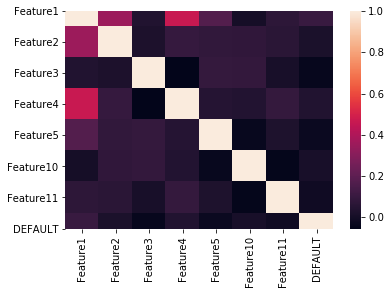

In [ ]:
corr_matrix = df.corr('spearman')
sns.heatmap(corr_matrix)

From the heatmap above, we see that Feature1 and Feature4 are correlated more than the others. I club the effects of them both by dividing Feature1 by Feature4 

In [ ]:
df2['Feature1_4'] = df2['Feature1'] / df2['Feature4']
df2.drop(['Feature1','Feature4'], axis=1, inplace=True)

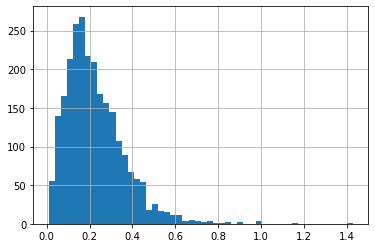

In [ ]:
# Checking distribution

df2['Feature1_4'].hist(bins=50)

In [ ]:
X = df2.drop(['DEFAULT'], axis = 1)
Y = df2['DEFAULT']

In [ ]:
X = StandardScaler().fit_transform(X)

In [ ]:
LR = LogisticRegression(random_state=0, solver='newton-cg', max_iter=1000, class_weight='balanced')

In [ ]:
evaluate_model(X, Y, LR, scoring='roc_auc')

0.140625 sec
************ SCORE CARD ************
Training Score:0.5684029765311963
Cross V Score: 0.5579486755883826 +/- 0.04775986885123962
Testing Score: 0.5666666666666667
Cross & Test Diff: -0.008717991078284082
[[368 284]
 [ 41  57]]
              precision    recall  f1-score   support

           0       0.90      0.56      0.69       652
           1       0.17      0.58      0.26        98

    accuracy                           0.57       750
   macro avg       0.53      0.57      0.48       750
weighted avg       0.80      0.57      0.64       750



In [ ]:
RF = RandomForestClassifier(n_estimators=500, class_weight='balanced')
evaluate_model(X, Y, RF, scoring='roc_auc')

4.171875 sec
************ SCORE CARD ************
Training Score:1.0
Cross V Score: 0.5507580343274603 +/- 0.04539115481846824
Testing Score: 0.8706666666666667
Cross & Test Diff: -0.3199086323392064
[[652   0]
 [ 97   1]]
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       652
           1       1.00      0.01      0.02        98

    accuracy                           0.87       750
   macro avg       0.94      0.51      0.48       750
weighted avg       0.89      0.87      0.81       750



## Final Model - CatBoost

I use CatBoost algorithm as the final algorithm for its state of the art performance and ability to handle categorical features automatically without preprocessing. I use the recommended parameters for the model tuning

In [ ]:
from catboost import CatBoostClassifier, Pool

In [ ]:
X = df.drop(['DEFAULT'], axis = 1)
Y = df['DEFAULT']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42, stratify=Y)

In [ ]:
CatB = CatBoostClassifier(iterations=143, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function= 'Logloss', eval_metric='AUC',use_best_model=True,random_seed=42, class_weights={0: 1.1506912442396313, 1: 7.636085626911315})

In [ ]:
CatB.fit(X_train, y_train, cat_features=cat_features,eval_set=(X_test, y_test))

0:	test: 0.5753881	best: 0.5753881 (0)	total: 96.3ms	remaining: 13.7s
1:	test: 0.5994350	best: 0.5994350 (1)	total: 115ms	remaining: 8.14s
2:	test: 0.5991690	best: 0.5994350 (1)	total: 122ms	remaining: 5.7s
3:	test: 0.6135204	best: 0.6135204 (3)	total: 135ms	remaining: 4.68s
4:	test: 0.6190059	best: 0.6190059 (4)	total: 162ms	remaining: 4.48s
5:	test: 0.6062977	best: 0.6190059 (4)	total: 185ms	remaining: 4.21s
6:	test: 0.6094356	best: 0.6190059 (4)	total: 201ms	remaining: 3.9s
7:	test: 0.6179338	best: 0.6190059 (4)	total: 219ms	remaining: 3.7s
8:	test: 0.6256886	best: 0.6256886 (8)	total: 243ms	remaining: 3.62s
9:	test: 0.6298203	best: 0.6298203 (9)	total: 248ms	remaining: 3.29s
10:	test: 0.6295778	best: 0.6298203 (9)	total: 261ms	remaining: 3.13s
11:	test: 0.6243036	best: 0.6298203 (9)	total: 278ms	remaining: 3.04s
12:	test: 0.6212126	best: 0.6298203 (9)	total: 289ms	remaining: 2.89s
13:	test: 0.6191467	best: 0.6298203 (9)	total: 295ms	remaining: 2.71s
14:	test: 0.6219012	best: 0.6298

120:	test: 0.6414330	best: 0.6415582 (118)	total: 1.52s	remaining: 276ms
121:	test: 0.6402279	best: 0.6415582 (118)	total: 1.53s	remaining: 264ms
122:	test: 0.6406661	best: 0.6415582 (118)	total: 1.55s	remaining: 252ms
123:	test: 0.6409321	best: 0.6415582 (118)	total: 1.56s	remaining: 239ms
124:	test: 0.6414956	best: 0.6415582 (118)	total: 1.57s	remaining: 227ms
125:	test: 0.6414956	best: 0.6415582 (118)	total: 1.58s	remaining: 213ms
126:	test: 0.6414956	best: 0.6415582 (118)	total: 1.58s	remaining: 200ms
127:	test: 0.6415112	best: 0.6415582 (118)	total: 1.59s	remaining: 186ms
128:	test: 0.6415112	best: 0.6415582 (118)	total: 1.6s	remaining: 174ms
129:	test: 0.6417460	best: 0.6417460 (129)	total: 1.6s	remaining: 160ms
130:	test: 0.6422468	best: 0.6422468 (130)	total: 1.61s	remaining: 148ms
131:	test: 0.6416364	best: 0.6422468 (130)	total: 1.64s	remaining: 136ms
132:	test: 0.6416364	best: 0.6422468 (130)	total: 1.64s	remaining: 123ms
133:	test: 0.6417460	best: 0.6422468 (130)	total: 1.6

In [ ]:
preds = CatB.predict(X_test)

In [ ]:
print(confusion_matrix(y_test, preds))

[[419 233]
 [ 47  51]]


In [ ]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.90      0.64      0.75       652
           1       0.18      0.52      0.27        98

    accuracy                           0.63       750
   macro avg       0.54      0.58      0.51       750
weighted avg       0.81      0.63      0.69       750

